In [1]:
from os import sys
sys.path.append("../../meshAfterParty/")

In [2]:
import skeleton_utils as sk
import soma_extraction_utils as sm
import trimesh_utils as tu
import trimesh
import numpy_utils as nu
import numpy as np
from importlib import reload
import networkx as nx
import time
import compartment_utils as cu
import networkx_utils as xu
import matplotlib_utils as mu

sm = reload(sm)

In [3]:
#Setting where base neuron is
segment_id = 91216997676870145
current_mesh_file = f"/notebooks/neuron_mesh_tools/test_neurons/spine_detection/{segment_id}_excitatory_1.off"


# **** Phase 1 ****

# Starting from the very beginning of a neuron mesh

In [4]:
current_neuron = trimesh.load_mesh(current_mesh_file)

In [5]:
sk.graph_skeleton_and_mesh(main_mesh_verts=current_neuron.vertices,
                          main_mesh_faces=current_neuron.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

/usr/local/lib/python3.6/dist-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


# Doing the soma detection

In [6]:
soma_mesh_list,run_time,total_soma_list_sdf = sm.extract_soma_center(segment_id,
                                             current_neuron.vertices,
                                             current_neuron.faces)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 15000.0 
large_mesh_threshold_inner = 10000.0 
soma_size_threshold = 1250.0 
soma_size_threshold_max = 12000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 2496
xvfb-run -n 2496 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/neuron_91216997676870145.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/neuron_91216997676870145_decimated.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/decimation_meshlab_25399505.mls
Total found significant pieces before Poisson = [<trimesh.Trimesh(vertices.shape=(41880, 3), faces.shape=(84664, 3))>]
----- working on large mesh #0: <trimesh.Trimesh(vertices.shape=(41880, 3), faces.shape=(84664, 3))>
pre_largest_mesh_path = /notebooks/neuron_mesh_tools/meshAfterPart

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma

Total found significant pieces AFTER Poisson = [<trimesh.Trimesh(vertices.shape=(27910, 3), faces.shape=(55820, 3))>]
----- working on mesh after poisson #0: <trimesh.Trimesh(vertices.shape=(27910, 3), faces.shape=(55820, 3))>
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 5336
xvfb-run -n 5336 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/neuron_91216997676870145_decimated_largest_piece_poisson_largest_inner.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/neuron_91216997676870145_decimated_largest_piece_poisson_largest_inner_decimated.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/91216997676870145/decimation_meshlab_25863909.mls
done exporting decimated mesh: neuron_91216997676870145_decimated_largest_piece_poisson_largest_inner.off
1) Starting: Mesh importing and Pymesh fix
loading mesh from vertices and triangles array
1) Finished: Mes

# At this point assume that there are somas (if not would just skip to the limb skeleton stuff)

In [7]:
# Visualizing the somas: 
total_soma = tu.combine_meshes(soma_mesh_list)
soma_meshes = total_soma
sk.graph_skeleton_and_mesh(main_mesh_verts=soma_meshes.vertices,
                          main_mesh_faces=soma_meshes.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [8]:
# geting the soma centers
if len(soma_mesh_list) <= 0:
    print(f"**** No Somas Found for Mesh {segment_id} so just one mesh")
    soma_mesh_list_centers = []
else:
    #compute the soma centers
    print(f"Soma List = {soma_mesh_list}")

    soma_mesh_list_centers = sm.find_soma_centroids(soma_mesh_list)
    print(f"soma_mesh_list_centers = {soma_mesh_list_centers}")

Soma List = [<trimesh.Trimesh(vertices.shape=(2416, 3), faces.shape=(4787, 3))>]
soma_mesh_list_centers = [array([817077.71183775, 920243.23071192, 972867.56096854])]


# getting the soma submeshes that are connected to each soma and identifiying those that aren't (and eliminating any mesh pieces inside the soma)

In [9]:
main_mesh_total = current_neuron
sig_th_initial_split=15

#finding the mesh pieces that contain the soma
#splitting the current neuron into distinct pieces
split_meshes = tu.split_significant_pieces(
                            main_mesh_total,
                            significance_threshold=sig_th_initial_split,
                            print_flag=False)

print(f"# total split meshes = {len(split_meshes)}")


#returns the index of the split_meshes index that contains each soma    
containing_mesh_indices = sm.find_soma_centroid_containing_meshes(soma_mesh_list_centers,
                                        split_meshes)

containing_mesh_indices

# total split meshes = 8


{0: 0}

In [10]:
# filtering away any of the inside floating pieces: 
sm = reload(sm)
non_soma_touching_meshes = [m for i,m in enumerate(split_meshes)
                 if i not in list(containing_mesh_indices.values())]


#Adding the step that will filter away any pieces that are inside the soma
if len(non_soma_touching_meshes) > 0 and len(soma_mesh_list) > 0:
    """
    *** want to save these pieces that are inside of the soma***
    """
    
    non_soma_touching_meshes,inside_pieces = sm.filter_away_inside_soma_pieces(soma_mesh_list,non_soma_touching_meshes,
                                    significance_threshold=sig_th_initial_split,
                                    return_inside_pieces = True)                                                      


split_meshes # the meshes of the original mesh
containing_mesh_indices #the mapping of each soma centroid to the correct split mesh
soma_containing_meshes = sm.grouping_containing_mesh_indices(containing_mesh_indices)

soma_touching_meshes = [split_meshes[k] for k in soma_containing_meshes.keys()]

    
print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")
print(f"# of inside pieces = {len(inside_pieces)}")
print(f"# of soma containing seperate meshes = {len(soma_touching_meshes)}")
print(f"meshes with somas = {soma_containing_meshes}")

There were 7 pieces found after size threshold
# of non soma touching seperate meshes = 5
# of inside pieces = 2
# of soma containing seperate meshes = 1
meshes with somas = {0: [0]}


# Soma Extraction was great (but it wasn't the original soma faces), so now need to get the original soma faces and the original non-soma faces of original pieces

In [11]:
from importlib import reload
sm = reload(sm)
tu = reload(tu)

"""
for each soma touching mesh get the following:
1) original soma meshes
2) significant mesh pieces touching these somas
3) The soma connectivity to each of the significant mesh pieces
-- later will just translate the 


Process: 

1) Final all soma faces (through soma extraction and then soma original faces function)
2) Subtact all soma faces from original mesh
3) Find all significant mesh pieces
4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all
   the available somas
Conclusion: Will have connectivity map


"""
limb_threshold = 2000

soma_touching_mesh_data = dict()

for z,(mesh_idx, soma_idxes) in enumerate(soma_containing_meshes.items()):
    soma_touching_mesh_data[z] = dict()
    print("\n\n----Working on soma-containing mesh piece {z}----")

    #1) Final all soma faces (through soma extraction and then soma original faces function)
    current_mesh = split_meshes[mesh_idx]

    current_soma_mesh_list = [soma_mesh_list[k] for k in soma_idxes]

    mesh_pieces_without_soma = sm.subtract_soma(current_soma_mesh_list,current_mesh,
                                                significance_threshold=250)

    mesh_pieces_without_soma_stacked = tu.combine_meshes(mesh_pieces_without_soma)
    
    # find the original soma faces of mesh
    soma_faces = tu.original_mesh_faces_map(current_mesh,mesh_pieces_without_soma_stacked,matching=False)
    soma_meshes = current_mesh.submesh([soma_faces],append=True)
    
    # finding the non-soma original faces
    non_soma_faces = tu.original_mesh_faces_map(current_mesh,soma_meshes,matching=False)
    non_soma_stacked_mesh = current_mesh.submesh([non_soma_faces],append=True)
    
    # 3) Find all significant mesh pieces
    sig_non_soma_pieces,insignificant_limbs = tu.split_significant_pieces(non_soma_stacked_mesh,significance_threshold=limb_threshold,
                                                     return_insignificant_pieces=True)
   
    
    soma_touching_mesh_data[z]["branch_meshes"] = sig_non_soma_pieces
    
    #4) Backtrack significant mesh pieces to orignal mesh and find connectivity of each to all the available somas
    # get all the seperate mesh faces

    #How to seperate the mesh faces
    seperate_soma_meshes,soma_face_components = tu.split(soma_meshes,only_watertight=False)
    soma_touching_mesh_data[z]["soma_meshes"] = seperate_soma_meshes
    
    
    soma_to_piece_connectivity = dict()
    for i,curr_soma in enumerate(seperate_soma_meshes):
        connected_mesh_pieces,connected_mesh_pieces_vertices  = tu.mesh_pieces_connectivity(
                        main_mesh=current_mesh,
                        central_piece=curr_soma,
                        periphery_pieces = sig_non_soma_pieces,
                        return_vertices = True)
        #print(f"soma {i}: connected_mesh_pieces = {connected_mesh_pieces}")
        soma_to_piece_connectivity[i] = connected_mesh_pieces
    
    
    soma_touching_mesh_data[z]["soma_to_piece_connectivity"] = soma_to_piece_connectivity

print(f"# of insignificant_limbs = {len(insignificant_limbs)} with trimesh : {insignificant_limbs}")
soma_touching_mesh_data



----Working on soma-containing mesh piece {z}----

inside Soma subtraction
mesh pieces in subtact soma BEFORE the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(79199, 3), faces.shape=(158736, 3))>, <trimesh.Trimesh(vertices.shape=(38141, 3), faces.shape=(76413, 3))>, <trimesh.Trimesh(vertices.shape=(37975, 3), faces.shape=(76070, 3))>, <trimesh.Trimesh(vertices.shape=(1376, 3), faces.shape=(2764, 3))>, <trimesh.Trimesh(vertices.shape=(184, 3), faces.shape=(355, 3))>]
There were 5 pieces found after size threshold
mesh pieces in subtact soma AFTER the filtering inside pieces = [<trimesh.Trimesh(vertices.shape=(79199, 3), faces.shape=(158736, 3))>, <trimesh.Trimesh(vertices.shape=(38141, 3), faces.shape=(76413, 3))>, <trimesh.Trimesh(vertices.shape=(37975, 3), faces.shape=(76070, 3))>, <trimesh.Trimesh(vertices.shape=(1376, 3), faces.shape=(2764, 3))>, <trimesh.Trimesh(vertices.shape=(184, 3), faces.shape=(355, 3))>]
Total Time for soma mesh cancellation = 0.717
# of insi

{0: {'branch_meshes': [<trimesh.Trimesh(vertices.shape=(79199, 3), faces.shape=(158736, 3))>,
   <trimesh.Trimesh(vertices.shape=(38141, 3), faces.shape=(76413, 3))>,
   <trimesh.Trimesh(vertices.shape=(37975, 3), faces.shape=(76070, 3))>,
   <trimesh.Trimesh(vertices.shape=(1376, 3), faces.shape=(2764, 3))>],
  'soma_meshes': array([<trimesh.Trimesh(vertices.shape=(13539, 3), faces.shape=(26997, 3))>,
         <trimesh.Trimesh(vertices.shape=(118, 3), faces.shape=(229, 3))>,
         <trimesh.Trimesh(vertices.shape=(32, 3), faces.shape=(57, 3))>,
         <trimesh.Trimesh(vertices.shape=(15, 3), faces.shape=(17, 3))>],
        dtype=object),
  'soma_to_piece_connectivity': {0: [0, 1, 2, 3], 1: [], 2: [3], 3: []}}}

# ****Soma Touching mesh Data has the branches and the connectivity (So this is where you end up skipping if you don't have somas)***

# Working on the Actual skeleton of all of the branches

In [12]:
sk = reload(sk)
xu = reload(xu)

import time
global_start_time = time.time()

for j,(soma_containing_mesh_idx,mesh_data) in enumerate(soma_touching_mesh_data.items()):
    print(f"\n-- Working on Soma Continaing Mesh {j}--")
    current_branches = mesh_data["branch_meshes"]
    
    #skeletonize each of the branches
    total_skeletons = []
    
    for z,branch in enumerate(current_branches):
        print(f"\n    -- Working on branch {z}--")
        curren_skeleton = sk.skeletonize_connected_branch(branch)
        #clean the skeleton
            # --------  Doing the cleaning ------- #
        clean_time = time.time()
        filter_end_node_length=5000,
        new_cleaned_skeleton = sk.clean_skeleton(curren_skeleton,
                                distance_func=sk.skeletal_distance,
                          min_distance_to_junction=filter_end_node_length,
                          return_skeleton=True,
                          print_flag=False)
        print(f"    Total time for skeleton and cleaning of branch {z}: {time.time() - clean_time}")
        if len(new_cleaned_skeleton) == 0:
            raise Exception(f"Found a zero length skeleton for limb {z} of trmesh {branch}")
        total_skeletons.append(new_cleaned_skeleton)
    
    soma_touching_mesh_data[j]["branch_skeletons"] = total_skeletons
    
print(f"Total time for skeletonization = {time.time() - global_start_time}")


-- Working on Soma Continaing Mesh 0--

    -- Working on branch 0--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 1581
xvfb-run -n 1581 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_390049.mls
-----Time for Screened Poisson= 17.599452018737793


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma

     Starting Calcification
Before mesh subtraction number of skeleton edges = 2924
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 158736


No adjacent faces detected! Did you merge vertices?



Total Mesh subtraction time = 38.4378



len_subgraphs AT BEGINNING of the loop


all graph is one component!

Total time for skeleton stitching = 0.522514820098877
The process was using a temp folder
Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 0: 10.09607744216919

    -- Working on branch 1--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 571
xvfb-run -n 571 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_538748.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


-----Time for Screened Poisson= 12.86734127998352


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


     Starting Calcification
Before mesh subtraction number of skeleton edges = 1470
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 76413



Total Mesh subtraction time = 17.1031



len_subgraphs AT BEGINNING of the loop


all graph is one component!
Total time for skeleton stitching = 0.20578932762145996
The process was using a temp folder

Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 1: 3.2077929973602295

    -- Working on branch 2--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP

LEAVING LOOP, MESH VALIDATED
Using port = 6140
xvfb-run -n 6140 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_697485.mls


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!


-----Time for Screened Poisson= 13.701874732971191


face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma

     Starting Calcification
Before mesh subtraction number of skeleton edges = 1463
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 76070



Total Mesh subtraction time = 18.0311



len_subgraphs AT BEGINNING of the loop


all graph is one component!
Total time for skeleton stitching = 0.21517300605773926
The process was using a temp folder

Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 2: 3.4967315196990967

    -- Working on branch 3--
     Starting Screened Poisson
IN INPUT FILE VALIDATION LOOP
LEAVING LOOP, MESH VALIDATED
Using port = 6555
xvfb-run -n 6555 -s "-screen 0 800x600x24" meshlabserver $@  -i /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None.off -o /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/None_poisson.off -s /notebooks/neuron_mesh_tools/meshAfterParty/development/temp/poisson_408977.mls
-----Time for Screened Poisson= 5.335187911987305
     Starting Calcification
Before mesh subtraction number of skeleton edges = 48
Inside mesh subtraction, len(main_mesh_bbox_restricted.faces) = 2764



Total Mesh subtraction time = 0.3066



len_subgraphs AT BEGINNING of the loop


all graph is one component!
Total time for skeleton stitching = 0.05521082878112793
The process was using a temp folder

Using Distance measure skeletal_distance


    Total time for skeleton and cleaning of branch 3: 0.061783552169799805
Total time for skeletonization = 162.70804023742676


In [13]:
# save off the data and rename it for use in phase 2
# Save our current
print("hello")
saved_file = f"./soma_mesh_data/soma_touching_mesh_data_{segment_id}.npz"
np.savez(saved_file,soma_touching_mesh_data=soma_touching_mesh_data)
current_mesh_data = soma_touching_mesh_data

hello


# Lets have an alert if there was more than one soma disconnected meshes

In [14]:
if len(soma_touching_mesh_data.keys()) > 1:
    raise Exception("More than 1 disconnected meshes that contain somas")

# ******* Phase 2 ********

# Importing and visualizing the preprocessed data (for sped up testing)

In [15]:
# saved_file = "../../Platinum_Compartment/soma_touching_mesh_data.npz"
saved_file = f"./soma_mesh_data/soma_touching_mesh_data_{segment_id}.npz"
current_mesh_data = nu.load_dict(saved_file)

In [16]:
# visualizing the original neuron
current_neuron = trimesh.load_mesh(current_mesh_file)
sk.graph_skeleton_and_mesh(main_mesh_verts=current_neuron.vertices,
                          main_mesh_faces=current_neuron.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [17]:
# visualizing the somas that were extracted
soma_meshes = tu.combine_meshes(current_mesh_data[0]["soma_meshes"])
sk.graph_skeleton_and_mesh(main_mesh_verts=soma_meshes.vertices,
                          main_mesh_faces=soma_meshes.faces,
                           main_mesh_color = [0.,1.,0.,0.8]
                          )

In [18]:
# # Visualize the extracted branches
# # visualize all of the branches and the meshes
# sk.graph_skeleton_and_mesh(other_meshes=list(current_mesh_data[0]["branch_meshes"]) + list(current_mesh_data[0]["soma_meshes"]),
#                           other_meshes_colors="random",
#                            other_skeletons = current_mesh_data[0]["branch_skeletons"],
#                           other_skeletons_colors="random")

# Cleaning each limb through distance and decomposition, checking that all cleaned branches are connected components and then visualizing

In [19]:
skelton_cleaning_threshold = 4001
total_cleaned = []
for j,curr_skeleton_to_clean in enumerate(current_mesh_data[0]["branch_skeletons"]):
    print(f"\n---- Working on Limb {j} ----")
    start_time = time.time()
    print(f"before cleaning limb size of skeleton = {curr_skeleton_to_clean.shape}")
    distance_cleaned_skeleton = sk.clean_skeleton(
                                                curr_skeleton_to_clean,
                                                distance_func=sk.skeletal_distance,
                                                min_distance_to_junction = skelton_cleaning_threshold,
                                                return_skeleton=True,
                                                print_flag=False) 
    #make sure still connected componet
    distance_cleaned_skeleton_components = nx.number_connected_components(sk.convert_skeleton_to_graph(distance_cleaned_skeleton))
    if distance_cleaned_skeleton_components > 1:
        raise Exception(f"distance_cleaned_skeleton {j} was not a single component: it was actually {distance_cleaned_skeleton_components} components")
        
    print(f"after DISTANCE cleaning limb size of skeleton = {distance_cleaned_skeleton.shape}")
    cleaned_branch = sk.clean_skeleton_with_decompose(distance_cleaned_skeleton)
    
    cleaned_branch_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cleaned_branch))
    if cleaned_branch_components > 1:
        raise Exception(f"cleaned_branch {j} was not a single component: it was actually {cleaned_branch_components} components")
    
    #do the cleanin ghtat removes loops from branches
    print(f"After DECOMPOSITION cleaning limb size of skeleton = {cleaned_branch.shape}")
    print(f"Total time = {time.time() - start_time}")
    total_cleaned.append(cleaned_branch)
    
current_mesh_data[0]["branch_skeletons_cleaned"] = total_cleaned


---- Working on Limb 0 ----
before cleaning limb size of skeleton = (3099, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (3099, 2, 3)
After DECOMPOSITION cleaning limb size of skeleton = (3099, 2, 3)
Total time = 1.945723295211792

---- Working on Limb 1 ----
before cleaning limb size of skeleton = (1439, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (1439, 2, 3)
After DECOMPOSITION cleaning limb size of skeleton = (1439, 2, 3)
Total time = 0.6343886852264404

---- Working on Limb 2 ----
before cleaning limb size of skeleton = (1388, 2, 3)
Using Distance measure skeletal_distance
no small end nodes to get rid of so returning whole skeleton
after DISTANCE cleaning limb size of skeleton = (1388, 2, 3)
After DECOMPOSITION cleaning limb size of skeleton = (1388, 2, 3)
Tota

In [20]:
# checking all cleaned branches are connected components

for k,cl_sk in enumerate(current_mesh_data[0]["branch_skeletons"]): 
    n_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cl_sk)) 
    if n_components > 1:
        raise Exception(f"Original limb {k} was not a single component: it was actually {n_components} components")
    
for k,cl_sk in enumerate(current_mesh_data[0]["branch_skeletons_cleaned"]): 
    n_components = nx.number_connected_components(sk.convert_skeleton_to_graph(cl_sk)) 
    if n_components > 1:
        raise Exception(f"Cleaned limb {k} was not a single component: it was actually {n_components} components")

In [21]:
# visualize all of the branches and the meshes
sk.graph_skeleton_and_mesh(other_meshes=list(current_mesh_data[0]["branch_meshes"]) + list(current_mesh_data[0]["soma_meshes"]),
                          other_meshes_colors="random",
                           other_skeletons = current_mesh_data[0]["branch_skeletons_cleaned"],
                          other_skeletons_colors="random",
                          mesh_alpha=0.15)

# Decomposing of limbs into branches and finding mesh correspondence (using adaptive mesh correspondence followed by a water fill for conflict and empty faces), checking that it went well with no empty meshes and all connected component graph when constructed from branches, plus visualization at end

In [22]:
sk = reload(sk)
tu = reload(tu)
cu = reload(cu)
from tqdm.notebook import tqdm
import time
import itertools

start_time = time.time()

limb_correspondence = dict()
soma_containing_idx= 0

total_branch_meshes = []
total_branch_skeletons = []

empty_submeshes = []
for soma_containing_idx in current_mesh_data.keys():
    for limb_idx,curr_limb_mesh in enumerate(current_mesh_data[soma_containing_idx]["branch_meshes"]):
        print(f"Working on limb #{limb_idx}")
        limb_correspondence[limb_idx] = dict()
        curr_limb_sk = current_mesh_data[soma_containing_idx]["branch_skeletons_cleaned"][limb_idx]
        curr_limb_branches_sk_uneven = sk.decompose_skeleton_to_branches(curr_limb_sk) #the line that is decomposing to branches
        
        for j,curr_branch_sk in tqdm(enumerate(curr_limb_branches_sk_uneven)):
            limb_correspondence[limb_idx][j] = dict()
            
            
            curr_branch_face_correspondence, width_from_skeleton = cu.mesh_correspondence_adaptive_distance(curr_branch_sk,
                                          curr_limb_mesh,
                                         skeleton_segment_width = 1000)
            
            
            
            if len(curr_branch_face_correspondence) > 0:
                curr_submesh = curr_limb_mesh.submesh([list(curr_branch_face_correspondence)],append=True)
            else:
                curr_submesh = trimesh.Trimesh(vertices=np.array([]),faces=np.array([]))
                
            limb_correspondence[limb_idx][j]["branch_skeleton"] = curr_branch_sk
            limb_correspondence[limb_idx][j]["correspondence_mesh"] = curr_submesh
            limb_correspondence[limb_idx][j]["correspondence_face_idx"] = curr_branch_face_correspondence
            limb_correspondence[limb_idx][j]["width_from_skeleton"] = width_from_skeleton
            
            total_branch_meshes.append(curr_submesh)
            total_branch_skeletons.append(curr_branch_sk)
            
            if len(curr_submesh.faces) == 0:
                empty_submeshes.append(dict(limb_idx=limb_idx,branch_number=j))
            
            
print(f"Total time = {time.time() - start_time}")

Working on limb #0


--> Not exactly one containing mesh: []

filtered_measurements = [306.18435996 164.22597655 320.93684659 185.87849631 217.94330252
 251.00499048 262.25326051 296.86120903 257.11532315 144.65189333
 128.82100806 104.68459826 158.87720196 318.90974933 266.58070655
 118.5231398  146.41572193 319.43353738 317.42565882 266.98595163
 390.08884696 196.05186124 185.90565911 197.4488117  255.15040715
 291.52137985 260.25805147 270.84939026 250.44665622 309.31147766
 237.95821117 205.27048126 238.88457181 288.94043997 307.73504073
 265.08063211 310.24675726 285.62741771 313.42043387 256.89512763
 243.98617422 250.51216791 258.26886148 290.82657715 190.10023584
 406.82606503 329.01228185 235.992931   260.93733799 225.77334366
 161.99115345 185.95295585 231.74739996 258.63388838 210.02627189
 313.22634487 322.43607762 324.47299944 246.30920012 218.13108486
 298.84847971 311.7848004  257.62907546 242.97475281 257.21430447
 320.93611786 229.10587453 208.23192555 270.02911594 341.90279253
 209.432999

--> Not exactly one containing mesh: []




filtered_measurements = [188.24206233 194.04254988 168.72931602 224.18061184 259.43832192
 263.10473162 202.28895849 143.53594302 170.25516255 315.98872958
 289.60127234 287.95423867 347.52230351 156.52103479 257.85869915
 254.62103835 200.74995267 183.09933382 227.07056466 236.03656644
 249.02021478 243.20407612 247.49998633 191.09856609 226.33506707
 244.60434127 243.01690994 233.39976856 188.67797426 185.40058927
 279.65156499 271.34969466 229.28025803]
new_threshold = 686.3735147248935


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [227.9019619  234.02996061 236.10258903 118.41187423 239.53486684
 328.51210815 371.65097685 114.6544457  212.84161617 325.39932111
 278.79966763 188.58486265 168.16394579 243.16202505 379.30854423
 388.12690728 195.07475336 398.14477072 411.02481122 334.21131021
 217.91408987 353.96940653 303.80581443 308.50495721 200.51783228
 177.23634351 288.25089305 208.46927173 227.28790817 212.51340425
 360.09373446 205.46495094 147.26588244 202.63817977 192.82398399
 412.39582119 297.69231932 266.93792371 260.51391928 256.81160681
 203.77616072 267.80593605 173.2028088  295.44274228 280.51603002
 229.91487459 291.80895861 175.9126138  193.46682152 260.84903507
 387.60034841 191.95244011 206.13701271 214.21177598 250.32603976
 179.05307739 164.48143883 316.01512733 365.85122317 194.42829172
 323.7763082  326.15883955 241.96123827 302.41841912 302.512313

--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [478.27600523 431.78436967 365.71242793 453.35487131 643.66521778
 327.52530361 474.44108703 385.93262019 312.49478088 327.06614887]
new_threshold = 1491.1891486225632



filtered_measurements = [537.55378647 304.42056418 321.17403102 387.00037611 415.49036725
 473.0203327  395.74156203 308.96508197 330.90938835 417.42982008
 505.22037506 536.96086903 334.78953683 527.64042343 525.57393645
 298.76187914 314.81964781 306.87120896 345.90581191 359.92335747
 358.54097328 392.63932715 306.08878448 352.33578285 339.60664663
 295.96283255 351.73523027 292.32375627 314.61592258 325.56997643
 288.07156852 252.25364262 366.66913589 316.29009898 291.78858276
 339.75666824 303.3363786  336.28208746 359.96089237 487.79207553
 243.56982664 410.63839054]
new_threshold = 1389.499990944562


--> Not exactly one containing mesh: []

filtered_measurements = [ 56.04213087 115.26905451  85.66952679  89.86783586  70.74818833
 103.94891267 135.88743816]
new_threshold = 253.59355228100816


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [11]
branch_touching_number = [11, 1]
most_branch_containing_piece = 0



filtered_measurements = [295.68591133 316.78240193 302.62600142 299.1724448  448.0988641
 299.57834922 375.44576519 466.23354283 426.34572074 275.44647517
 321.62563838 321.80165967 413.02196859 334.92170057 300.64884274
 330.04993665 318.49369468 322.75574205 277.44817583 270.52889133
 237.63228995 281.7573398  320.03712873 282.21145615 272.77994288
 414.40746336 326.03860298]
new_threshold = 1028.475389104331


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [153.44806824 129.88816552  78.79380648]
new_threshold = 350.99487482504236


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [6]
branch_touching_number = [6, 2]
most_branch_containing_piece = 0



filtered_measurements = [371.73098558 261.42606552 199.08866765 367.38601302 379.77271362
 328.64633433 271.69620838 241.25406446 248.81682415 249.29918835
 285.37107184 405.64551819 482.0217752  352.11057335 316.47491416
 403.15608222 227.74230252 313.99952015 330.92499412 373.18187558
 318.81176742 190.67832529 251.56829487 274.07914996 323.33845547
 209.00272494 272.49319726 296.13226408 432.06954593 322.16507394
 237.27074502 366.77065799 460.8594539  406.5556513  427.91277783
 307.67985656 318.88953823 320.69816557 287.52717341 210.91630295
 334.52496491 243.72505799 207.51869345 338.03101088]
new_threshold = 1142.22503644871



filtered_measurements = [631.62913151 518.40332256 489.44569594 290.63971342 304.30464399
 306.06778455 371.66402401 439.29088182 360.72610384 347.61552691
 393.17869606 652.85975487 460.63728938]
new_threshold = 1527.3101362979094



filtered_measurements = [319.89353559 421.96547583 375.2133132  269.4815759  217.82669072
 258.93288094 269.60308911 163.55411057 365.31834945 325.62254213
 278.66670962 320.84514654 374.20967804 334.66626692 296.72058015
 382.87080418 305.52177333]
new_threshold = 1000.1516723110303



filtered_measurements = [470.54501849 437.10448182 542.73638628 493.78861682 571.62015705
 642.91677276 532.29398616 598.47747141 542.89050146 465.94091144
 635.60990588 505.64762117 523.76345023 461.12090227 449.76097032
 708.15077748 728.45495617 448.56770449 444.07868277 522.6031957
 468.85180424 498.80426975 517.73938608 481.90295131 597.68540192
 535.46756646 610.90541691 520.99420625 496.59497518 438.96978102
 541.43613725]
new_threshold = 1531.152399865135


--> Not exactly one containing mesh: []

filtered_measurements = [285.28526248 535.01078048 360.45713609 310.60725825 306.97026386
 507.40203189 292.74344783 286.69155074 376.68315739 340.63270509
 426.54406797 492.65115826 272.57908127 359.97963326 361.33270332
 296.63684869 321.45662822 353.32312535 303.08484162 345.15930479
 474.02634881 408.52113106 241.85419184 348.86924822 420.94573484
 230.69962599 400.24083653 414.2203495  357.07260654 285.64602212
 227.87032881 358.51903338 354.89427582 443.42727466 204.44370855
 390.62543888 340.17306538 489.22930948 280.66654652 285.7356604
 255.5110707  307.13745528 428.70724988 223.85398884 460.48290845
 473.05118341 436.96894079 380.77925355 350.53591634 229.48640605
 286.26696238 305.30611889 350.07537734 344.38112157 304.16161374
 229.79932084 335.76049768 363.38990585 265.17480013 327.83540401
 327.63640681 291.40537715 170.09748504 232.52190442 380.65292538
 292.54008371 442.6029982  244.30537832]
new_threshold = 1250.5950118387823


--> Not exactly one containing mesh: []




filtered_measurements = [462.02786513 422.1381585  391.7716087  385.14742826 324.48684664
 571.22056503 403.1625434  392.09602903 310.46842122 303.41006604]
new_threshold = 1313.3229229236506



filtered_measurements = [753.12444956 847.09450735 646.26329513 569.62539574 590.80672523
 681.14902331 691.99250182 615.62754306 579.63895504 600.69208447
 956.48431593 613.31441558 588.3426425  671.86247665 615.77039022
 689.64568547 823.87885967 592.65519864 600.9538851  678.4876162
 743.51181489]
new_threshold = 2003.042137194276


--> Not exactly one containing mesh: []

filtered_measurements = [118.79858217 151.80317972 177.68484806 202.41346492 177.00457553
 157.95146163 204.8638017  162.33695055 177.22833033 154.44399662
 178.00668046 169.43926972 171.28685882 234.81368328 240.07203788
 220.09845355 203.1382239  230.31335981 175.10052691 167.1308246
 196.03029679 273.15008212 197.55299581 182.39082676 200.04656129
 206.63825179 240.97875904 234.52753149 219.10494305 242.53579857
 231.81688182 270.93345188]
new_threshold = 439.7487989951137


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
THERE WERE NO FACES THAT FIT THE DISTANCE (439.7487989951137) and Z transform requirements
So just skipping this edge

branch_touching_number = [39]
branch_touching_number = [39, 1]
most_branch_containing_piece = 0



filtered_measurements = [923.34356874 825.86693861 797.6402868  784.31349167 733.37915966
 797.02972347 891.76308714 967.51619607 896.98036135 825.13929505
 716.39874228 722.28767852 744.06763021 758.36520548 748.10338884
 836.4959066  947.13586825]
new_threshold = 1823.6700118755475


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [ 989.03268215  969.55649823  920.3148379   960.36204457  980.78185085
  959.36270596  923.69804294  900.83814247 1043.91797376 1086.54656034
 1157.64000518 1185.18328472 1389.27351481 1561.75972641 1341.96528468
  380.81150863]
new_threshold = 3221.2454842668412


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [478.90893194 276.02888451 448.41633968 505.1340265  318.33747414
 359.83270644 430.92605628 529.53864173 411.73358057 449.20201367
 411.98618621 401.59046104 404.01943484 422.78189869 339.12893215
 365.43100296 508.67824127 296.02437362 435.9921312  441.68043841
 367.19100586 401.08640773 349.90316737 365.33616376 493.64673322
 453.2284214  498.4489544  494.74053604 354.77906446 305.61955385
 479.83919869 461.84914976 497.28962256 438.99474812 332.661474
 497.27150861 452.97094651 501.04687006 502.32447202 424.48836525
 415.86121088 432.4729135  492.79720065 408.42032755 310.50369538
 345.85434391 468.83283317 474.23270302 431.45974335 462.24076097
 471.38666703 410.81946064 396.69130467 364.77354133 446.20211585
 345.25758553 371.27414038 488.56773304 403.15431417 538.39221532
 529.19394774 416.75669743 516.21664132 394.58232041 341.04897531
 442.56988088 491.91499964 374.48573868 440.42097977 491.4881829
 334.96229403 517.46151649 321.00542838 389.0307364  4


filtered_measurements = [110.55282244 218.42180998 160.78601491 194.95437603 273.64524441
 200.41677491  99.0475685  221.1215566  176.85809044 219.37288033]
new_threshold = 540.1284979839435



filtered_measurements = [456.3259869  391.10233098 374.27387025 425.83855142 382.07797748
 397.80217425 296.68366928 240.0295454  245.47756    515.75642023
 307.76987606 265.35730781 302.19832403 280.65054884 454.41643712]
new_threshold = 1214.6937923995793


--> Not exactly one containing mesh: []

filtered_measurements = [137.67971667 167.46370736 131.34431489 144.432163   116.81502006
 159.10209497 158.27585742]
new_threshold = 432.81925582965084


--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [160.51843497 116.73616587 100.79727849  59.92123923 167.65642103
 116.5587858   92.45848842  75.91037518  95.24640713  87.97038021
  85.73978834 156.75638178 188.62240355 152.31661973 154.84775781
 155.27799854 103.1502631  120.58807435  93.18221769  78.04116027
 125.19945537 159.77038771 142.13818976  87.39498487  99.76038262
 106.85280286 132.12374189 166.47036971  75.76177698]
new_threshold = 409.01387756812414


--> Not exactly one containing mesh: []
THERE WERE NO FACES THAT FIT THE DISTANCE (409.01387756812414) and Z transform requirements
So just skipping this edge
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [36]
branch_touching_number = [36, 2]
most_branch_containing_piece = 0



filtered_measurements = [271.03622326 318.21752634 322.94990753 315.18566147 275.58011637
 217.13618638 278.58608804]
new_threshold = 484.8219069610312



filtered_measurements = [ 80.06035235  75.01894582  66.81026557  86.78017317 149.19526209
 153.25340456 119.71427699  93.8371096 ]
new_threshold = 330.6465431301393


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [815.68457515 491.87645644 237.14341197]
new_threshold = 1658.5512281954977


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [430.52724379 283.08912552 270.17140654 249.56651226 290.65786722
 293.91551759 294.79378417 305.82665323 388.52867835]
new_threshold = 695.0049698215253



filtered_measurements = [157.58012511 500.72669968 262.36675344 458.80362318 187.34374192
 261.74684455 194.03407739 388.92403583 303.54477531 371.82767303]
new_threshold = 1187.5869391273245



filtered_measurements = [165.30142214 287.10393307 241.9020257  208.43871265 121.50329893
 156.68642496 237.46512551 168.24714556 105.43087972 150.42063492
 280.70285838 185.70100902 150.70556305 147.94561751 153.66129888
 123.45215684 131.32453463 113.10128758 172.87095815 221.52437961
 148.43365896 116.38546381 141.41866726 238.13400181 223.14822363]
new_threshold = 685.9739289351902




Working on limb #1


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [135.45161881 238.65462984 354.6028162  350.63626643 193.20235144
 197.26491131 348.96401231 183.95083972 284.94289134 460.35550006
 333.86691128 344.79402422 222.42427918 136.8151649  259.15934074
 249.88249987 414.29161803 125.04386123 163.36054676 181.71054687
 377.0994544  229.10225853 319.25962987 256.43476645 210.80089543
 349.6415887  397.61375381 313.97027857 314.02368238 240.01151345
 258.7600268  440.64869923 238.96017143 141.41719868 139.76685803
 245.08662522 226.96003258 204.14066781 269.9919993  412.25514229
 188.8297189  421.07164098 352.32009057 255.70099067 231.45353358
 224.32464737 258.5849137  205.01725792 434.90668997 243.71736375
 246.11589816 463.67349571 366.51637251 364.6136781  319.37150856
 436.45252302 358.75836263 242.27616724 263.30305963 269.37285935
 193.80014238 273.38086122 250.38703349 409.89536917 311.25076512
 260.37013665 287.82910844 281.197627

--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []

filtered_measurements = [ 89.12531695 110.85974294 102.88027616  98.72563661 108.99510895
  65.60641425]
new_threshold = 218.4451003051734


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [12]
branch_touching_number = [12, 1]
most_branch_containing_piece = 0



filtered_measurements = [282.8568422  357.11413111 394.63093378 553.58232034 536.0199563
 338.93095391 253.30442308 351.28650377 548.98960446 511.13593207
 259.17227404 266.30782818 311.43262384 276.15557401 354.79360149
 240.45798263 533.9593342  390.96022423 297.82324451 240.8839056
 528.63399841 293.94960958 360.51552676 215.82098882 326.0279015
 322.17278333 253.38518207 260.87325447 218.226485   215.91480546
 291.37032337 389.88006977 202.00519328 360.15211921 267.90731963
 432.23922129 257.75833527 259.97760977 321.29172479 411.95404851
 376.07472071 423.82522591 563.29694876 336.84321598 244.16186136
 342.55850722 334.05515155 414.30445979 569.63826676 227.91922994
 211.34699515 373.59547155 546.40482638 336.74813347 470.80533587
 317.50390366 268.66095689 260.75720729 299.46313547 386.00819492
 398.52497379 350.30502902 308.98066218 359.47182383 483.89766395
 423.44708536 562.58943488 357.52097647 543.79456356 566.27150157
 513.63331849 531.93614959 544.19243881 461.95209578 5


filtered_measurements = [339.51197633 201.45218353 250.34716457 375.29327027 358.73209541
 449.80065616 329.98741992 491.15120703 228.92892443 204.73188761
 485.38367285 218.88183185 357.26266353 307.25571317 296.74709045
 380.0912866  322.89858231 451.81059648 253.05237011 322.74247652
 213.96230301 411.16533399 418.75133262 369.00091674 181.95019726
 344.69603061 380.79802682 366.6012235  512.5145218  263.57671855
 256.14057601 368.04759374 287.97789207 328.26303765 307.37371499
 247.49074848 362.16535837 338.86483361 292.65997107 380.15829092
 351.21613112 231.79629541 385.31318286]
new_threshold = 1319.018492427866


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [ 74.99961146 153.07208607 131.88149391]
new_threshold = 313.40417028522637


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [221.95493376 154.07112564 136.79183007 203.98410871 155.98091731
 175.24632279 226.02384292 185.66339254 265.90640653 294.75680481]
new_threshold = 631.0406828820394


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [473.49986062 435.40588406 321.45597948 304.44972713]
new_threshold = 934.7544674435153



filtered_measurements = [375.77222064 441.81949238 381.0221202  228.74558383 198.40684882
 255.44028927]
new_threshold = 1000.3063218171077



filtered_measurements = [444.06378449 402.85770317 486.90874161 507.71058097 440.4578802
 389.72653388 533.68066664 562.43099108 480.48240018 481.22736985
 432.73819365 363.49889601 469.00976872 440.86450861 544.96670606
 337.75442923 316.29962215 349.84170274 441.44151191 323.95133657
 432.74589426 487.25057059 494.2106952  417.52566256 459.24392972
 327.98422178 424.33367388 595.07544337 412.22903053 433.88012763
 375.73252459 343.3213894  350.52358468 476.13666079]
new_threshold = 1144.715934523112



filtered_measurements = [365.44223216 185.34639949 179.54119684 310.85672789 383.92689588
 154.21992666 337.34398437 232.92300937 286.68271556 352.88593191
 292.56023113 358.3014576  261.63402669 231.21122076 341.69041938
 306.54800634 250.45632796 414.39837495 221.38115468 243.00574375
 360.32772128 218.95863864 191.18889269 175.41477542 266.7156552
 256.08274597 294.62520357 329.46611359 211.4899456  342.650394
 137.91067191 230.37878721 300.87796649 357.37748401 389.73613962
 183.89822973 157.9587169  252.74493831 369.13484293 289.62737302
 199.67221832 293.82960122 351.42072668 361.76778297 380.89594772
 231.86475325 191.79794495 187.61109933 235.16218379 262.38491562
 361.11039764 276.96436974 184.53123716 306.98262643 350.38244511
 198.50305419 210.62698053 345.90236145 317.40316344 280.85067267
 301.07759811]
new_threshold = 988.0604948467476



filtered_measurements = [257.79243569 362.59941137 381.15815626 319.14054986 428.64553799
 327.81216033 339.20412097 243.43049927 247.15307365 328.85097246
 365.85326181 347.42528811 460.5407024  423.34174794 275.73446746
 505.46706442 309.77406234 317.68725051 365.27248757 402.65593697]
new_threshold = 1052.161121797153



filtered_measurements = [ 82.45670421 171.68949007 181.88998991 118.80546531]
new_threshold = 376.61219244016786



filtered_measurements = [409.50820146 510.11428609 595.51068492 378.94990636 382.99118763
 491.13796499 373.27906574 402.54736849 464.20861574 378.13575991
 358.77639188 297.63410721 548.33791933 536.78727258]
new_threshold = 1300.0889250151977



filtered_measurements = [192.31951188 228.1093407  247.20200093 186.87751458 293.54424541
 265.62711806 405.01462534 197.16980771 240.40226151 365.69722329
 313.46275924 281.08618932 273.45673734 332.66267021 289.41326749
 296.27989477 235.45913441 343.06595605 308.1058959  230.48538585
 393.73698166 349.44601576 236.8805629  263.7025177  234.42652646
 380.90262341 249.23985413 226.84429192 238.53412376]
new_threshold = 910.5984320857408



filtered_measurements = [394.6176004  248.04887976 219.44024106 300.23139241 409.11282725
 415.36680631 380.60318854 383.29588763 444.32415608 350.07771285
 258.33564144 258.90571415 312.91410405 229.32717926 291.63172661
 403.46132388 371.94396363 250.19476522 287.22993027 270.91847161
 448.5400729  190.08383107 324.58848398 445.77357381 353.48054664
 215.84399914 318.28796078 355.70326948 436.81485091 237.85081535
 392.61641739 280.00052232 251.35502309 304.12815822 238.54105324
 221.19622799 222.45437827 273.84905572 200.09795215 167.09745324]
new_threshold = 1194.7667478590452


--> Not exactly one containing mesh: []

filtered_measurements = [246.0837753  249.69436054 170.59315914 214.10711076 115.56772443
 141.54111914 211.65949496]
new_threshold = 552.7618973326006


--> Not exactly one containing mesh: []




filtered_measurements = [296.45109168 211.976283   382.20978627 239.04644609 334.82639885
 345.51114221 315.53598029 384.60814637 247.41417336 260.21702243
 254.96359118 457.05825079 279.74528333 366.4775165  244.30556728
 341.88598775 332.28499215]
new_threshold = 1167.7053741807708




Working on limb #2


--> Not exactly one containing mesh: []

filtered_measurements = [530.25485959 477.58566528 536.21994597 684.68679945 874.67807241
 613.99973866 648.63509311 719.187455   634.42318428 556.0061137
 587.83044479]
new_threshold = 1715.118351800131


--> Not exactly one containing mesh: []




filtered_measurements = [276.67188553 267.20222557 265.70882082 150.3905904  119.81402129
 129.16930867 129.23439418 119.15783248 121.20027596 303.48403577]
new_threshold = 680.0520132063338



filtered_measurements = [ 85.27421769  94.27673674 108.7476426   82.18953128  95.96709747
  85.73031796]
new_threshold = 202.2032572530214



filtered_measurements = [ 87.00813484  74.04072362  75.97387082 135.26056778 144.4517636
  72.10276707 126.97222813 114.83427701]
new_threshold = 309.5382558419071


--> Not exactly one containing mesh: []

branch_touching_number = [11]
branch_touching_number = [11, 1]
most_branch_containing_piece = 0



filtered_measurements = [618.69094513 475.91117481 461.81317501 625.47636903 560.47903782
 537.04434337 690.89199016 470.87349711 419.58287111 491.63233804
 550.99225569 529.87156804 589.56522501 470.32563711 553.62134483
 552.91958916 564.22869902 614.29219946 629.54199107]
new_threshold = 1375.4191176454651



filtered_measurements = [377.78370956 278.93742321 335.66835791 363.86514294 319.07601311
 302.77336281 337.44436048 460.49078863 519.55735207 402.9808531
 483.70985024 505.08481568 361.19501763 377.62681891 369.49026735
 421.74737423 339.03999287 359.09065222 430.81680112 481.48951491
 419.05447462 461.77902655 344.34649697 537.0647075  401.55652631
 416.87853695 395.54174741 339.25942083 363.10559871 509.24914753
 431.66047375 422.26357296]
new_threshold = 1182.161539890262



filtered_measurements = [271.72592023 288.55755332]
new_threshold = 395.13940064851266


--> Not exactly one containing mesh: []

branch_touching_number = [5]
branch_touching_number = [5, 1]
most_branch_containing_piece = 0
filtered_measurements = [103.54653738  97.14664659 100.37984328]
new_threshold = 215.8965850890857


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []




filtered_measurements = [369.35991018 334.87168089 343.51527658 368.06892855 455.09179289
 335.05064269 321.47762649 338.70897294 294.19525745 385.0241867
 480.61693683 387.21137059 224.28433637 193.67278068 266.88596214
 278.63063081 266.34604533 368.76248868 485.08433235 341.45351035
 337.37323164 413.25431569 259.77181492 270.3991542  239.5192941
 399.66940467 328.48682187 418.3376451  255.50272576 198.86156518
 240.6943211  427.80568706 311.29677851 267.85825574 324.55179725
 209.91532513 329.50199107 316.88296077 295.36331393 307.73654667
 315.01956115 264.13537576 366.25992412 268.56422818 227.85743863
 386.49869457 239.4773389  295.4354054  247.9893375  289.73559435
 346.66877006 289.28772324 157.4745607  184.40661686 391.81543743
 320.21958473 205.22217979 211.7852794  302.16865832 307.74603764
 429.21210121 303.88906727 470.14677442 242.83392606 268.83245914
 248.77229883 218.8608934  415.61982423 213.57782798 440.346726
 424.29423723 297.73033575 408.25594887 297.91935498 49


filtered_measurements = [276.25487453 264.58210628 271.85930916 292.51610514 480.55393792
 317.86628857 403.86610539 232.51117958 259.27531858 382.18658455
 425.90830667 571.49587113 267.05091414 296.67057718 416.66387557
 275.82844765 393.90748758 372.90251524 540.16294242 327.45281722
 306.06639758 551.10122621 414.23572558 296.5097705  410.94711708
 360.96634249 267.21545917 422.76772627 383.78145908 411.61207911
 236.62123505 229.10076942 513.96821891 352.14365605 328.58003625
 523.25614203 452.17750216 293.88614039 184.29240325 234.92570252
 187.10135673 248.83862867 331.5269168  425.20968401 370.95601862
 304.56561856 352.03655602 276.26811144 284.33362176 392.56443397
 342.68719573 391.71306927 291.10024379 470.55247316 474.38629588
 312.31177796 275.7829682  559.78052615 297.63189031 338.1713535
 411.21034565 284.00339009 368.7661761  529.56957525 445.93697296
 265.98881674 444.65824276 322.31189052 345.35154903 310.58055582
 308.27408134 375.58634964 404.79596583 428.83167885


filtered_measurements = [214.01796932 361.68704106 407.17099144 358.47901566 399.66311762
 280.45668995 337.33746435 254.49756958 199.62402955 236.55275487
 339.39113161 440.17666874 236.45511072 320.02140416 339.57943332
 366.8253544  213.69795257 262.36310511 409.41605385 377.28799448
 308.25960083 308.08088395 382.46565254 229.78207972 270.6933786
 318.51718071 262.37990531 317.880893   243.68767359 483.99305483
 361.13274789 429.91174214 263.22564846 223.32812836 366.13235257
 217.98884338 271.41874633 467.94818652 469.60518001 338.34812815
 426.61554827 400.42040669 274.68419517 456.88862044 406.30812118
 353.00429415 432.19013574 380.25478431 285.41261753 170.39372978
 346.2849031  388.93767562 390.2326077  228.15815891 291.39688166
 307.94793173 483.6120764  205.46801744 343.9360227  286.03038253
 255.5884401  295.47488347 450.99240741 327.48482011 185.53064123
 218.39616302 324.97136094 278.94166181 291.33925012 302.47196802
 253.83025307 194.79905125 166.75837938 186.50817734

--> Not exactly one containing mesh: []

filtered_measurements = [233.81539846 186.30566542 312.40415151 223.39014514]
new_threshold = 495.22137032176636


--> Not exactly one containing mesh: []




filtered_measurements = [251.02226819 247.20352742 257.93468335 313.79070076 200.87675255
 194.27777324 162.3689653  134.24058592]
new_threshold = 693.9857348920744


--> Not exactly one containing mesh: []

filtered_measurements = [105.54369388 155.44749659  93.83804689]
new_threshold = 292.5528731431384


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [5]
branch_touching_number = [5, 1]
most_branch_containing_piece = 0



filtered_measurements = [360.30529677 365.62295287 209.36494303 237.25013048 330.65338508
 263.58327729 321.33435642 501.9968322  245.20553638 236.6986671
 303.50712955 349.05040828 288.21314697 243.36912119 398.92578724
 241.61614904 250.32406692 240.14656782 339.03022491 391.83908596
 400.77810208 250.01237515 193.26495941 336.11193561 219.83416666
 339.13404883 286.98385085 411.84909382 303.91212988 316.76506291
 256.56495453 189.26564918 176.60793233 325.4543681  312.78760885
 423.96601759 447.85015708 493.78239349 249.26647637 219.80411507
 346.32579943 339.00189613 276.18590387 480.04945719 301.84581874
 257.31381303 313.68777063]
new_threshold = 1278.8176539071542



filtered_measurements = [198.9256831  186.69712733 132.01943985 170.00109803]
new_threshold = 409.22825461133016



filtered_measurements = [313.42773013 287.66994355 203.30503966 295.42051727 345.68926224]
new_threshold = 708.3318330128247



filtered_measurements = [347.507409   433.894777   424.55151501 397.03426634 308.96714109
 241.95044676 201.41978759 443.4290523  305.74741048 185.85458581
 191.56697471 281.53336364 257.33917001 367.2402806  269.24730766
 176.46186853 434.43474781 396.9779213  298.34797082]
new_threshold = 1076.669326766795


--> Not exactly one containing mesh: []

filtered_measurements = [200.67143007  86.10092992 186.78483615 216.75959832]
new_threshold = 438.31360601804084


--> Not exactly one containing mesh: []

branch_touching_number = [5]
branch_touching_number = [5, 1]
most_branch_containing_piece = 0


--> Not exactly one containing mesh: []

filtered_measurements = [129.36602052 125.2481181  127.04646225 118.00489696 183.60619969
 171.12666304 141.91088411 169.10691805 262.87661232 226.16463891
 201.00479524 186.31628061 109.10163952 111.2484284 ]
new_threshold = 468.28408115253967


--> Not exactly one containing mesh: []



--> Not exactly one containing mesh: []

filtered_measurements = [177.31402235 318.11009797 287.96370521 196.73125321 315.16487506
 369.02127062 240.81686151 147.68858719 174.28459847 182.4521505
 276.96409761 252.26162521]
new_threshold = 742.2357678008193


--> Not exactly one containing mesh: []




filtered_measurements = [1382.00196137 1650.76519965]
new_threshold = 3161.451592218743



filtered_measurements = [663.1598191]
new_threshold = 909.9761516928163




Working on limb #3


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

filtered_measurements = [113.19161935  59.33920169 132.81013406  91.64746685  79.03756031
 110.4117165  183.01833026 136.26523671  86.5226696  118.02602697
  71.57467544 117.25258024  84.22725873 101.2638171  145.99291258
 113.89909651 101.41487985 117.03718129 154.9069833  159.37639484
 128.26031922 124.53760294 137.78052457  97.59332318  72.94579878
  83.0854182   89.76147509 147.84317277 112.16470239  88.99156629
 101.28048931 132.212578    94.06312584 124.34572578  92.62799435
  68.03095233  59.08716748  74.03640984  67.89263186]
new_threshold = 350.4685256210107


--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []
--> Not exactly one containing mesh: []

branch_touching_number = [40]
branch_touching_number = [40, 17]
most_branch_containing_piece = 0

Total time = 47.81223750114441


In [23]:
#couple of checks on how the decomposition went
nu = reload(nu)
sk = reload(sk)
empty_submeshes = []

for soma_containing_idx in current_mesh_data.keys():
    for limb_idx,curr_limb_mesh in enumerate(current_mesh_data[soma_containing_idx]["branch_meshes"]):
        print(f"\n---- checking limb {limb_idx}---")
        print(f"Limb {limb_idx} decomposed into {len(limb_correspondence[limb_idx])} branches")
        
        #get all of the skeletons and make sure that they from a connected component
        divided_branches = [limb_correspondence[limb_idx][k]["branch_skeleton"] for k in limb_correspondence[limb_idx]]
        divided_skeleton_graph = sk.convert_skeleton_to_graph(
                                        sk.stack_skeletons(divided_branches))
        
        divided_skeleton_graph_recovered = sk.convert_graph_to_skeleton(divided_skeleton_graph)
        
        cleaned_limb_skeleton = current_mesh_data[0]['branch_skeletons_cleaned'][limb_idx]
        print(f"divided_skeleton_graph_recovered = {divided_skeleton_graph_recovered.shape} and \n"
              f"current_mesh_data[0]['branch_skeletons_cleaned'].shape = {cleaned_limb_skeleton.shape}\n")
        if divided_skeleton_graph_recovered.shape != cleaned_limb_skeleton.shape:
            print(f"****divided_skeleton_graph_recovered and cleaned_limb_skeleton shapes not match: "
                            f"{divided_skeleton_graph_recovered.shape} vs. {cleaned_limb_skeleton.shape} *****")
        
        
        #check that it is all one component
        divided_skeleton_graph_n_comp = nx.number_connected_components(divided_skeleton_graph)
        print(f"Number of connected components in deocmposed recovered graph = {divided_skeleton_graph_n_comp}")
        
        cleaned_limb_skeleton_graph = sk.convert_skeleton_to_graph(cleaned_limb_skeleton)
        cleaned_limb_skeleton_graph_n_comp = nx.number_connected_components(cleaned_limb_skeleton_graph)
        print(f"Number of connected components in cleaned skeleton graph= {cleaned_limb_skeleton_graph_n_comp}")
        
        if divided_skeleton_graph_n_comp > 1 or cleaned_limb_skeleton_graph_n_comp > 1:
            raise Exception(f"One of the decompose_skeletons or cleaned skeletons was not just one component : {divided_skeleton_graph_n_comp,cleaned_limb_skeleton_graph_n_comp}")
        
        #check that when we downsample it is not one component:
        curr_branch_meshes_downsampled = [sk.resize_skeleton_branch(b,n_segments=1) for b in divided_branches]
        downsampled_skeleton = sk.stack_skeletons(curr_branch_meshes_downsampled)
        curr_sk_graph_debug = sk.convert_skeleton_to_graph(downsampled_skeleton)


        con_comp = list(nx.connected_components(curr_sk_graph_debug))
        if len(con_comp) > 1:
            raise Exception(f"There were more than 1 component when downsizing: {[len(k) for k in con_comp]}")
        else:
            print(f"The downsampled branches number of connected components = {len(con_comp)}")
        
        
        for j in limb_correspondence[limb_idx].keys():
            if len(limb_correspondence[limb_idx][j]["correspondence_mesh"].faces) == 0:
                empty_submeshes.append(dict(limb_idx=limb_idx,branch_idx = j))
        
print(f"Empty submeshes = {empty_submeshes}")

if len(empty_submeshes) > 0:
    raise Exception(f"Found empyt meshes after branch mesh correspondence: {empty_submeshes}")


---- checking limb 0---
Limb 0 decomposed into 29 branches
divided_skeleton_graph_recovered = (3099, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (3099, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1

---- checking limb 1---
Limb 1 decomposed into 17 branches
divided_skeleton_graph_recovered = (1439, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1439, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1

---- checking limb 2---
Limb 2 decomposed into 23 branches
divided_skeleton_graph_recovered = (1388, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (1388, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of con

In [24]:
# sk = reload(sk)
# import matplotlib_utils as mu
# mu = reload(mu)
# sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes,
#                           other_meshes_colors="random",
#                            other_skeletons=total_branch_skeletons,
#                            other_skeletons_colors="random"
#                           )

# Finishing off the face correspondence so get 1-to-1 correspondence of mesh face to skeletal piece

In [25]:
"""
Input: 
- full mesh
- current face coloring of mesh (could be incomplete) corresponding to skeletal pieces
(but doesn't need the skeletal pieces to do it's jobs, those are just represented in the labels)

Output: 
- better face coloring which has labels that:
    a. cover entire mesh
    b. the labels exist as only 1 connected component on the mesh



Pseudocode of what doing:
- clearing out the branch_mesh correspondence stored in limb_correspondence[limb_idx][k]["branch_mesh"]
- gets a list of how many subdivided branches there were (becuase this should be the number of labels) and the mesh of whole limb
- Builds a face to skeleeton branch correspondence bassed on the current  branch_piece["correspondence_face_idx"] that already exists
    This may have overlaps or faces mapped to zero branches that we need to resolve
- computes the percentage of empty and conflicting faces 
- makes sure that at least one face that corresponds to each branch piece (and throws error if so)

#Doing the resolution of the empty and conflicting faces:
- clears out all conflicting faces and leaves them just like the empty ones
- uses the filter_face_coloring_to_connected_components which only keeps the largest connected component of a label 
    (because the zeroing out of conflicting labels could have eliminated or split up some of the labels)
- if  a face was totally eliminated then add it back to the face coloring
(only does this once so a face could still be missing if one face totally overwrites another face)

**At this point: there is at one-to-one correspondence of mesh face to skeletal piece label OR empty label (-1)

# Using the waterfilling algorithm: designed at fixing the correspondence to empty label (-1) 
- get a submesh of the original mesh but only for those empty faces and divide into disconnecteed mesh pieces
- run through waterfilling algorithm to color each empty piece
- check that there are no more empty faces
- gets the one connected mesh component that corresponds to that label (get both the actual mesh and the mesh indexes)

#the output of all of the algorithm: 
- save the result back in  limb_correspondence[limb_idx][k]["branch_mesh"] so it is accurately updated


"""

'\nInput: \n- full mesh\n- current face coloring of mesh (could be incomplete) corresponding to skeletal pieces\n(but doesn\'t need the skeletal pieces to do it\'s jobs, those are just represented in the labels)\n\nOutput: \n- better face coloring which has labels that:\n    a. cover entire mesh\n    b. the labels exist as only 1 connected component on the mesh\n\n\n\nPseudocode of what doing:\n- clearing out the branch_mesh correspondence stored in limb_correspondence[limb_idx][k]["branch_mesh"]\n- gets a list of how many subdivided branches there were (becuase this should be the number of labels) and the mesh of whole limb\n- Builds a face to skeleeton branch correspondence bassed on the current  branch_piece["correspondence_face_idx"] that already exists\n    This may have overlaps or faces mapped to zero branches that we need to resolve\n- computes the percentage of empty and conflicting faces \n- makes sure that at least one face that corresponds to each branch piece (and throws e

In [26]:
#--- this is the function that will clean up a limb piece so have 1-1 correspondence

cu = reload(cu)
tu = reload(tu)

#things to prep for visualizing the axons
total_widths = []
total_branch_skeletons = []
total_branch_meshes = []

soma_containing_idx = 0
import time
for limb_idx in limb_correspondence.keys():
    mesh_start_time = time.time()
    #clear out the mesh correspondence if already in limb_correspondecne
    for k in limb_correspondence[limb_idx].keys():
        if "branch_mesh" in limb_correspondence[limb_idx][k]:
            del limb_correspondence[limb_idx][k]["branch_mesh"]
        if "branch_face_idx" in limb_correspondence[limb_idx][k]:
            del limb_correspondence[limb_idx][k]["branch_face_idx"]
    #geting the current limb mesh
    print(f"\n\nWorking on limb_correspondence for #{limb_idx}")
    no_missing_labels = list(limb_correspondence[limb_idx].keys()) #counts the number of divided branches which should be the total number of labels
    curr_limb_mesh = current_mesh_data[soma_containing_idx]["branch_meshes"][limb_idx]

    #set up the face dictionary
    face_lookup = dict([(j,[]) for j in range(0,len(curr_limb_mesh.faces))])

    for j,branch_piece in limb_correspondence[limb_idx].items():
        curr_faces_corresponded = branch_piece["correspondence_face_idx"]

        for c in curr_faces_corresponded:
            face_lookup[c].append(j)

    original_labels = set(list(itertools.chain.from_iterable(list(face_lookup.values()))))
    print(f"max(original_labels),len(original_labels) = {(max(original_labels),len(original_labels))}")
    
    
    if len(original_labels) != len(no_missing_labels):
        raise Exception(f"len(original_labels) != len(no_missing_labels) for original_labels = {len(original_labels)},no_missing_labels = {len(no_missing_labels)}")
    
    if max(original_labels) + 1 > len(original_labels):
        raise Exception("There are some missing labels in the initial labeling")
        
    
        
    #here is where can call the function that resolves the face labels
    face_coloring_copy = cu.resolve_empty_conflicting_face_labels(
                     curr_limb_mesh = curr_limb_mesh,
                     face_lookup=face_lookup,
                     no_missing_labels = list(original_labels)
    )
    

    # -- splitting the mesh pieces into individual pieces
    divided_submeshes,divided_submeshes_idx = tu.split_mesh_into_face_groups(curr_limb_mesh,face_coloring_copy)
    
    #-- check that all the split mesh pieces are one component --#

    #save off the new data as branch mesh
    for k in limb_correspondence[limb_idx].keys():
        limb_correspondence[limb_idx][k]["branch_mesh"] = divided_submeshes[k]
        limb_correspondence[limb_idx][k]["branch_face_idx"] = divided_submeshes_idx[k]
        total_widths.append(limb_correspondence[limb_idx][k]["width_from_skeleton"])
        total_branch_skeletons.append(limb_correspondence[limb_idx][k]["branch_skeleton"])
        total_branch_meshes.append(limb_correspondence[limb_idx][k]["branch_mesh"])
    
    print(f"Total time for limb mesh processing = {time.time() - mesh_start_time}")



Working on limb_correspondence for #0
max(original_labels),len(original_labels) = (28, 29)
empty_indices % = 0.07788403386755367
 conflict_indices % = 0.018281927225078116



Total time for limb mesh processing = 2.6255979537963867


Working on limb_correspondence for #1
max(original_labels),len(original_labels) = (16, 17)
empty_indices % = 0.09745723895148731
 conflict_indices % = 0.01529844398204494



Total time for limb mesh processing = 1.3446502685546875


Working on limb_correspondence for #2
max(original_labels),len(original_labels) = (22, 23)
empty_indices % = 0.07813855659261207
 conflict_indices % = 0.024267122387274877



Total time for limb mesh processing = 1.3928735256195068


Working on limb_correspondence for #3
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.4667149059334298
 conflict_indices % = 0.0



Total time for limb mesh processing = 0.11756610870361328


# Visualizing the results of getting the mesh to skeletal segment correspondence completely 1-to-1

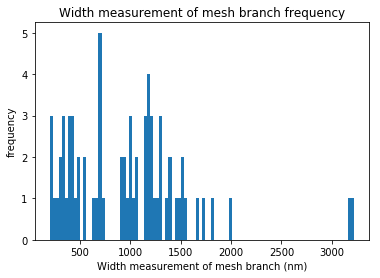

In [27]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,1)
bins = plt.hist(np.array(total_widths),bins=100)
ax.set_xlabel("Width measurement of mesh branch (nm)")
ax.set_ylabel("frequency")
ax.set_title("Width measurement of mesh branch frequency")
plt.show()

In [28]:
sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes,
                          other_meshes_colors="random",
                          other_skeletons=total_branch_skeletons,
                          other_skeletons_colors="random",
                          #html_path="two_soma_mesh_skeleton_decomp.html"
                          )

In [29]:
np.argmax([1,4,5,6])

3

In [30]:

sk.graph_skeleton_and_mesh(other_meshes=[total_branch_meshes[47]],
                          other_meshes_colors="random",
                          other_skeletons=[total_branch_skeletons[47]],
                          other_skeletons_colors="random",
                          html_path="two_soma_mesh_skeleton_decomp.html")

# PART 3: LAST PART OF ANALYSIS WHERE MAKES CONCEPT GRAPHS

In [31]:
import neuron
neuron = reload(neuron)
nu = reload(nu)
sk = reload(sk)

#getting mesh and skeleton dictionaries
limb_idx_to_branch_meshes_dict = dict()
limb_idx_to_branch_skeletons_dict = dict()
for k in limb_correspondence.keys():
    limb_idx_to_branch_meshes_dict[k] = [limb_correspondence[k][j]["branch_mesh"] for j in limb_correspondence[k].keys()]
    limb_idx_to_branch_skeletons_dict[k] = [limb_correspondence[k][j]["branch_skeleton"] for j in limb_correspondence[k].keys()]      

#getting the soma dictionaries
soma_idx_to_mesh_dict = dict()
for k,v in enumerate(current_mesh_data[0]["soma_meshes"]):
    soma_idx_to_mesh_dict[k] = v

soma_idx_connectivity = current_mesh_data[0]["soma_to_piece_connectivity"]




limb_concept_networkx,limb_labels = neuron.generate_limb_concept_networks_from_global_connectivity(
    limb_idx_to_branch_meshes_dict = limb_idx_to_branch_meshes_dict,
    limb_idx_to_branch_skeletons_dict = limb_idx_to_branch_skeletons_dict,
    soma_idx_to_mesh_dict = soma_idx_to_mesh_dict,
    soma_idx_connectivity = soma_idx_connectivity,
    current_neuron=current_neuron,
    return_limb_labels=True
    )

#Before go and get concept maps:
print("Sizes of dictionaries sent")
for curr_limb in limb_idx_to_branch_skeletons_dict.keys():
    print((len(limb_idx_to_branch_skeletons_dict[curr_limb]),len(limb_idx_to_branch_meshes_dict[curr_limb])))
    
    
print("\n\n Sizes of concept maps gotten back")
for curr_idx in limb_concept_networkx.keys():
    for soma_idx,concept_graph in limb_concept_networkx[curr_idx].items():
        print(len(np.unique(list(concept_graph.nodes()))))



------Working on limb 0 -------
inside loop len(curr_limb_divided_meshes) = 29 len(curr_limb_divided_skeletons) = 29
--- Working on soma_idx: 0----
inside inner loop len(curr_limb_divided_skeletons) = 29
closest_endpoint = [812893. 917171. 961773.]
At the start, starting_node = [18]
edge_endpoints_to_process was empty so exiting loop after 29 iterations
starting_node = [18]
Total time for branches to concept conversion = 0.22133827209472656

After concept mapping size = 29
Local time for concept mapping = 1.9007813930511475


------Working on limb 1 -------
inside loop len(curr_limb_divided_meshes) = 17 len(curr_limb_divided_skeletons) = 17
--- Working on soma_idx: 0----
inside inner loop len(curr_limb_divided_skeletons) = 17
closest_endpoint = [819985. 931411. 997775.]
At the start, starting_node = [8]
edge_endpoints_to_process was empty so exiting loop after 17 iterations
starting_node = [8]
Total time for branches to concept conversion = 0.10458493232727051

After concept mapping 

# the final data that will be ported over to the Neuron class

In [32]:

current_neuron
"""
whole neuron to be used for other processing
"""

# The 0 at the front is to say it is the first seperated mesh containing somas (could be multiple)
current_mesh_data[0].keys()
"""
soma_meshes
soma_to_piece_connectivity
"""
"""
limb_correspondence[0][0].keys() --> the exact limb and the exact branch

AKA [limb_idx][branch_idx]

"""
limb_correspondence[0][0]["branch_skeleton"]
limb_correspondence[0][0]["width_from_skeleton"]
limb_correspondence[0][0]["branch_mesh"]
limb_correspondence[0][0]["branch_face_idx"]



limb_concept_networkx
limb_labels


#things that weren't used in classification but still would have knowledge of:
insignificant_limbs # the limbs that were filtered away after did soma subtraction because not big enough
print(f"# of non soma touching seperate meshes = {len(non_soma_touching_meshes)}")# meshes that were seperate from soma mesh
print(f"# of inside pieces = {len(inside_pieces)}") #inside of the soma meshes
"""
Concept networks for limbs and labels of all limbs
"""

# of non soma touching seperate meshes = 5
# of inside pieces = 2


'\nConcept networks for limbs and labels of all limbs\n'

# Plotting for visualizataions (used for platinum update report)

In [33]:
curr_limb_idx = 2

In [34]:
#plotting the mesh
sk = reload(sk)
mu = reload(mu)
random_colors_used = sk.graph_skeleton_and_mesh(
    other_meshes=[v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_meshes_colors="random",
                          other_skeletons=[v["branch_skeleton"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_skeletons_colors="random",
                            mesh_alpha=0.8,
                          return_other_colors=True)
random_colors_used_no_alpha = random_colors_used[:,:-1]

In [35]:
#plotting the skeleton
sk = reload(sk)
mu = reload(mu)
sk.graph_skeleton_and_mesh(#other_meshes=total_branch_meshes[:node_to_check_to],
                          #other_meshes_colors="random",
                          other_skeletons=[v["branch_skeleton"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_skeletons_colors="random",
                            mesh_alpha=0.05)


In [36]:
# get the label:
limb_labels[curr_limb_idx]

'Normal'

In [37]:
limb_concept_networkx

{0: {0: <networkx_utils.GraphOrderedEdges at 0x7fbbfae1ecf8>},
 1: {0: <networkx_utils.GraphOrderedEdges at 0x7fbbf9283390>},
 2: {0: <networkx_utils.GraphOrderedEdges at 0x7fbbf1f77208>},
 3: {0: <networkx_utils.GraphOrderedEdges at 0x7fbbfae1ef60>,
  2: <networkx_utils.GraphOrderedEdges at 0x7fbbf9411898>}}

In [38]:
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    print((len(np.unique(list(concept_graph.nodes()))),len([v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ])))

(23, 23)


Starting from soma index 0 with starting_coordinate and mesh: [[822585.  916563.8 978161.5]]


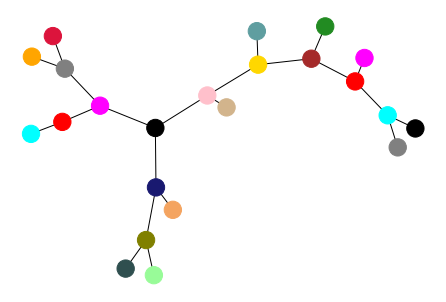

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    print(f"Starting from soma index {soma_idx} with starting_coordinate and mesh: "
          f"{xu.get_node_attributes(concept_graph,attribute_name='starting_coordinate')}")
    # plotting the concept network with the same colors
    nx.draw(concept_graph,node_color=random_colors_used_no_alpha) 
    plt.show()
    print("\n\n")

In [40]:
# Try plotting the points in 3D: random_colors_used = sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes[:node_to_check_to],
mesh_midpoints =  [np.array([np.mean(k.vertices,axis=0)]) for k in [v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ]]
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    graph_nodes_skeleton = np.array(mesh_midpoints)[concept_graph.edges_ordered()].reshape(-1,2,3)
    [k for k in graph_nodes_skeleton]
    random_colors_used[:,-1] = 1


    sk.graph_skeleton_and_mesh(other_scatter=mesh_midpoints,
                              other_scatter_colors=random_colors_used,
                              other_skeletons=graph_nodes_skeleton,
                              other_skeletons_colors="black",
                                                   scatter_size=3)



In [41]:


    
# Try plotting the points in 3D: random_colors_used = sk.graph_skeleton_and_mesh(other_meshes=total_branch_meshes[:node_to_check_to],
mesh_midpoints =  [np.array([np.mean(k.vertices,axis=0)]) for k in [v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ]]
for soma_idx,concept_graph in limb_concept_networkx[curr_limb_idx].items():
    graph_nodes_skeleton = np.array(mesh_midpoints)[concept_graph.edges_ordered()].reshape(-1,2,3)
    [k for k in graph_nodes_skeleton]
    random_colors_used[:,-1] = 1


    sk.graph_skeleton_and_mesh(
        other_meshes=[v["branch_mesh"] for k,v in limb_correspondence[curr_limb_idx].items() ],
                          other_meshes_colors="random",other_scatter=mesh_midpoints,
                              other_scatter_colors=random_colors_used,
                              other_skeletons=graph_nodes_skeleton,
                              other_skeletons_colors="black",
                                                   scatter_size=1)